In [1]:
from rio_tiler.io import Reader
from rio_tiler.models import ImageData
from rio_tiler.colormap import cmap
import matplotlib.pyplot as plt
from rasterio import windows
cm = cmap.get("viridis")
from scipy.interpolate import RectBivariateSpline
import cv2
import pyproj
import numpy as np

In [2]:
def mapplot(fn, start_x, start_y, zoom, grid=3):
    tiles = np.empty(shape=(grid, grid, 256, 256, 1))
    for x in range(grid):
        for y in range(grid):
            tiles[y, x] = fn(start_x+x, start_y+y, zoom)
    tiles = tiles.swapaxes(1, 2)
    tiles = tiles.reshape(grid*256, grid*256)
    plt.imshow(tiles)
    plt.show()

In [3]:
def original(x, y, zoom):
    with Reader(tif) as dst:
        img = dst.tile(x, y, zoom, tilesize=tilesize)
        return img.data_as_image()

In [4]:
def basic(x, y, zoom):
    with Reader(tif) as dst:
        img = dst.tile(x, y, zoom, tilesize=tilesize)
        img_buffered = dst.tile(x, y, zoom, tilesize=tilesize, buffer=0)
        stats = img_buffered.statistics()
        bs = stats.get('b1')
        bstats = (bs.min, bs.max)
        img.rescale(
            in_range=(bstats,)
        )
        return img.data_as_image()

In [5]:
def equalized(x, y, zoom, buffer_tiles=0):
    with Reader(tif) as dst:
        img = dst.tile(x, y, zoom, tilesize=tilesize, buffer=tilesize*buffer_tiles)
        stats = img.statistics()
        bs = stats.get('b1')
        bstats = (bs.min, bs.max)
        img.rescale(
            in_range=(bstats,),
        )
        eq_img = cv2.equalizeHist(img.data_as_image())
        bounds = windows.bounds(windows.Window(tilesize, tilesize, tilesize, tilesize), img.transform)
        img = img.clip(bounds)
        pos_start, pos_end = buffer_tiles*tilesize, (buffer_tiles+1)*tilesize
        new_img = ImageData(
            eq_img[pos_start:pos_end, pos_start:pos_end],
            assets=img.assets,
            crs=img.crs,
            bounds=img.bounds,
        )
        return new_img.data_as_image()

In [12]:
def image_to_uint8(img):
    data = img.data_as_image()
    return cv2.normalize(src=data, dst=None, alpha=0, beta=2**8, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

def clahe(x, y, zoom, buffer_tiles=1):
    with Reader(tif) as dst:
        img = dst.tile(x, y, zoom, tilesize=tilesize)
        img_buffered = dst.tile(x, y, zoom, tilesize=tilesize, buffer=tilesize*buffer_tiles)
        clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(3, 3))
        eq_img = clahe.apply(image_to_uint8(img_buffered))
        bounds = windows.bounds(windows.Window(tilesize, tilesize, tilesize, tilesize), img.transform)
        img = img.clip(bounds)
        pos_start, pos_end = buffer_tiles*tilesize, (buffer_tiles+1)*tilesize
        d = np.ma.MaskedArray(eq_img[pos_start:pos_end, pos_start:pos_end], mask=img.mask)
        new_img = ImageData(
            d,
            assets=img.assets,
            crs=img.crs,
            bounds=bounds,
        )
        return new_img.data_as_image()

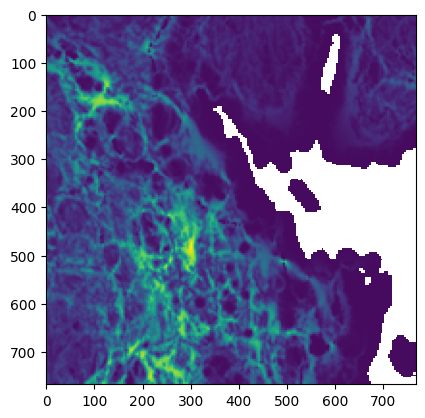

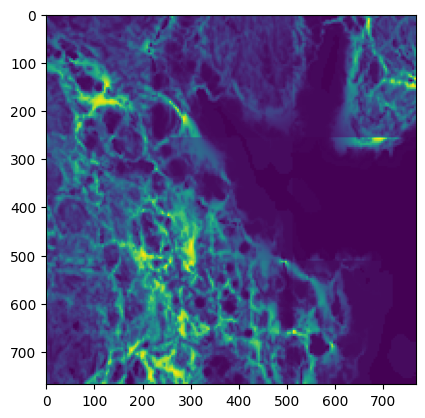

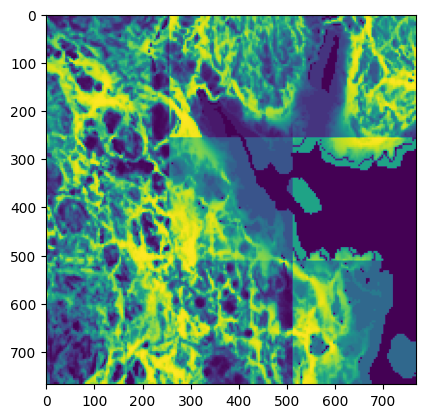

MaskError: Mask and data not compatible: data size is 65536, mask size is 0.

In [13]:
zoom, *tile = map(int, "11/1081/599".split("/"))
tilesize = 256
tif = "http://nginx-dev/data/layers/test.tif.cog"

mapplot(original, *tile, zoom)
mapplot(basic, *tile, zoom)
mapplot(equalized, *tile, zoom)
mapplot(clahe, *tile, zoom)